Exercise 2: Train a VAE to generate images similar to the images of the given fashion-mnist dataset. 

The dataset is given in two csv files (train and test). ALL data should be used to train the VAE. The csv files have headers, their first columns contain labels, and the remaining columns contain image data.

Your should: write dataloaders, train an appropriate VAE, show a few samples and their corresponding decoded images, as well as a few of the generated samples.


In [1]:
!wget -O data.zip https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
!unzip data.zip

--2023-01-16 11:47:15--  https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tzs174hrjs1rbzs/FashionMNIST.zip [following]
--2023-01-16 11:47:15--  https://www.dropbox.com/s/raw/tzs174hrjs1rbzs/FashionMNIST.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc22e25210baf160c5c2c6c00c7f.dl-eu.dropboxusercontent.com/cd/0/inline/B0rV6Lf1w8JUuv2GszyebZ0Ttx2JbKmgCE5_qfZHHgzlYVUgvZZ79zZ_LWsxeUCTR4eX97NLdNhKjkqdN8Y0teUSOXMe87OayEQOU5n7XbTbboW0KZttMbJok4GvpSTCQS6j1mLJT0l4aNEeo-8LF5C2aIsAL28pL8U7t8xZW64gbQ/file# [following]
--2023-01-16 11:47:16--  https://uc22e25210baf160c5c2c6c00c7f.dl-eu.dropboxusercontent.com/cd/0/inline/B0rV6Lf1w8JUuv2GszyebZ0Ttx2JbKmgCE5_qfZHHgzlYVUgvZZ79zZ_L

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import random
import pandas as pd
%matplotlib inline

### Loading Data

In [41]:
train_df = pd.read_csv('fashion-mnist_train.csv')
test_df = pd.read_csv('fashion-mnist_test.csv')
train = pd.concat((test_df, train_df), axis = 0)
print('length of concat:',len(train))


length of concat: 70000


In [42]:
class FasionData(Dataset):
  def __init__(self, data, transform=None):
    super().__init__()

    self.images = data.iloc[:, 1:].to_numpy().astype(np.float32).reshape(-1,28,28)/255

    self.labels = data.iloc[:, 0].to_numpy()
    
    self.transform = transform 

    
  def __len__(self,test=False):
    return len(self.test_imagess) if test else len(self.images)

  def __getitem__(self, index):
    # if not test:
    image = self.images[index]
    image = torch.tensor(np.expand_dims(image, axis=0))
    if self.transform:
      image = self.transform(image)
    label = torch.tensor(self.labels[index])
    return image, label

In [43]:
train_data = FasionData(train)
train_loader = DataLoader(train_data, batch_size=32)

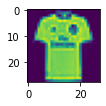

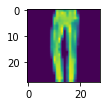

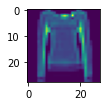

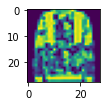

In [60]:
for i in range(4):
  plt.subplot(2,4,i+1)
  plt.imshow(train_data.images[i])
  plt.show()

### Network

In [44]:
class AutoEncoder(nn.Module):
  def __init__(self, nz=32):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(1, 16, 3, 2, 1)
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32,64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear(64*4*4, 128)
    self.ebn4 = nn.BatchNorm1d(128)
    
    self.dlinear1 = nn.Linear(nz,128)
    self.dbn1 = nn.BatchNorm1d(128)
    self.dlinear2 = nn.Linear(128,64*4*4)
    self.dbn2 = nn.BatchNorm2d(64)
    self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding =1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dconv3 = nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding =1)
    
    self.ulinear = nn.Linear(128,nz)
    self.slinear = nn.Linear(128,nz)


  def encoder (self,x):
    x = F.leaky_relu(self.econv1(x))
    x = self.ebn1(x)
    x = F.leaky_relu(self.econv2(x))
    x = self.ebn2(x)
    x = F.leaky_relu(self.econv3(x))
    x = self.ebn3(x)
    x = x.view(-1,64*4*4)
    x = F.leaky_relu(self.elinear1(x))
    x = self.ebn4(x)
    return x
  
  def decoder(self, x):
    x = F.leaky_relu(self.dlinear1(x))
    x = self.dbn1(x)
    x = F.leaky_relu(self.dlinear2(x))
    x = x.view(-1, 64,4,4)
    x = self.dbn2(x)
    x = F.leaky_relu(self.dconv1(x))
    x = self.dbn3(x)
    x = F.leaky_relu(self.dconv2(x))
    x = self.dbn4(x)
    x = torch.sigmoid(self.dconv3(x))
    return x

  def get_params(self,x):
    u = self.ulinear(x)
    logvar = self.slinear(x)
    return u, logvar

  def reparametarization(self, u, logvar):
    std = torch.exp(logvar/2)
    z = u + std*torch.randn_like(u)
    return z

  def forward(self,x):
    ex = self.encoder(x)
    u, logvar = self.get_params(ex)
    z = self.reparametarization(u, logvar)
    x = self.decoder(z)
    return ex,z, x, u, logvar 

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net = AutoEncoder(32).to(device)

summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
       BatchNorm2d-2           [-1, 16, 14, 14]              32
            Conv2d-3             [-1, 32, 7, 7]           4,640
       BatchNorm2d-4             [-1, 32, 7, 7]              64
            Conv2d-5             [-1, 64, 4, 4]          18,496
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Linear-7                  [-1, 128]         131,200
       BatchNorm1d-8                  [-1, 128]             256
            Linear-9                   [-1, 32]           4,128
           Linear-10                   [-1, 32]           4,128
           Linear-11                  [-1, 128]           4,224
      BatchNorm1d-12                  [-1, 128]             256
           Linear-13                 [-1, 1024]         132,096
      BatchNorm2d-14             [-1, 6

### Training

0 157.10082319751382
1 101.22376912459731
2 90.88234059885144
3 84.71343083679676
4 80.95021449774504
5 78.51234256848693
6 76.8133974019438
7 75.5970957595855
8 74.61930418200791
9 73.86263009905815


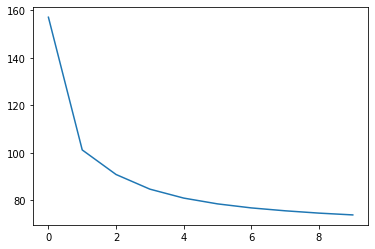

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net = AutoEncoder(32).to(device)

num_epochs = 10
lr = 0.0001
mm = 0.5

optimizer = optim.Adam(net.parameters(), lr = lr)
ls = []

def var_loss(Xhat, X, u, logvar):
  KLD_WEIGHT = 0.0012
  term1 = F.mse_loss(Xhat, X)
  term2 = torch.mean(torch.sum(0.5*(1+logvar - torch.exp(logvar) - u**2), axis = 1), axis =0)
  return (1- KLD_WEIGHT)* term1 - KLD_WEIGHT*term2

for epoch in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].to(device)
    ex, z,Xhat, u, logvar = net(X)
    loss = var_loss(Xhat, X,u, logvar )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(epoch, total_loss)

  ls.append(total_loss)

plt.plot(ls)


In [47]:
net.eval()
z = torch.randn(64,32)
Xhat = net.decoder(z)


torch.Size([64, 1, 28, 28]) torch.Size([28, 28]) torch.float32


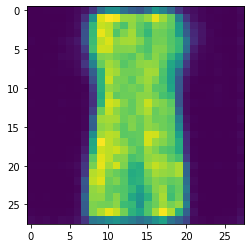

In [58]:
img = Xhat[0, 0]
print(Xhat.shape, img.shape, img.dtype)
plt.imshow(img.detach().cpu().numpy())


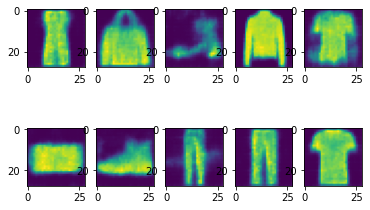

In [57]:
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(Xhat[i,0,:,:].detach().cpu().numpy())
  